In [1]:
!pip install emoji

In [2]:
import pandas as pd
import emoji
import re
import emoji
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
import pickle
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
import numpy as np
from keras.models import load_model

In [3]:
csv_file = "C:/Users/ramya/Documents/Master Final Project/Phase 2/Project/features.csv"
tweet_df = pd.read_csv(csv_file)
tweet_df.shape

(217231, 22)

In [4]:
tweet_df.head(10)

,tweet_id,post_text,parent_id,parent_user,create_date,tweet_length,emoticon_x,mention_count_x,hashtag_count_x,like_count,...,tweet_user,follower_count,following_count,history_tweets,account_age,hashtag_count_y,mention_count_y,description_length,emoticon_y,group
0,1260590991641362436,So you left a 69 page guidebook but no PPE or ...,0,0,2020-05-13T15:21:27.000Z,278,0,0,0,301,...,64,28000.0,1017.0,6,12.0,0,1,140,1,0
1,1257296415849697280,How people act when they get a little bit of p...,1256955387066101760,111921,2020-05-04T13:09:59.000Z,139,0,0,1,19,...,64,28000.0,1017.0,6,12.0,0,1,140,1,0
2,1288771853822103552,More tales from the NHS frontline are emerging...,0,0,2020-07-30T09:42:08.000Z,301,0,1,0,194,...,135,73909.0,2835.0,5,12.0,0,1,158,0,1
3,1251209120528637952,DEVELOPING: A crowd of protesters could be see...,0,0,2020-04-17T18:01:15.000Z,302,0,1,0,7650,...,290,234555.0,7014.0,138,16.0,0,0,156,0,1
4,1339567071588442113,"Latest we expect on checks, *as of now*, per a...",0,0,2020-12-17T13:44:12.000Z,276,0,0,0,621,...,361,98474.0,1405.0,100,12.0,0,2,156,0,0
5,1265997510738358272,Wisconsin election officials agree to send vot...,0,0,2020-05-28T13:25:02.000Z,93,0,0,0,959,...,457,17034217.0,1685.0,280,17.0,0,0,27,0,0
6,1262485169338036227,Trump says he is taking hydroxychloroquine to ...,0,0,2020-05-18T20:48:14.000Z,125,0,0,0,241,...,457,17034217.0,1685.0,280,17.0,0,0,27,0,0
7,1281796363869716485,CDC: Covid-19 death toll is twice as high amon...,0,0,2020-07-11T03:44:02.000Z,123,0,0,0,476,...,457,17034217.0,1685.0,280,17.0,0,0,27,0,0
8,1244740000148787211,Opinion: Jerry Falwell Jr.’s coronavirus respo...,0,0,2020-03-30T21:35:16.000Z,113,0,0,0,1208,...,457,17034217.0,1685.0,280,17.0,0,0,27,0,0
9,1298387890746073096,"Opinion: Sorry, Democrats. Trump’s convention ...",1298345607812329478,91004,2020-08-25T22:32:50.000Z,81,0,0,0,1701,...,457,17034217.0,1685.0,280,17.0,0,0,27,0,0


In [5]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217231 entries, 0 to 217230
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tweet_id            217231 non-null  int64  
 1   post_text           217231 non-null  object 
 2   parent_id           217231 non-null  int64  
 3   parent_user         217231 non-null  int64  
 4   create_date         217231 non-null  object 
 5   tweet_length        217231 non-null  int64  
 6   emoticon_x          217231 non-null  int64  
 7   mention_count_x     217231 non-null  int64  
 8   hashtag_count_x     217231 non-null  int64  
 9   like_count          217231 non-null  int64  
 10  retweet_count       217231 non-null  int64  
 11  questionmark_count  217231 non-null  int64  
 12  tweet_user          217231 non-null  int64  
 13  follower_count      217231 non-null  float64
 14  following_count     217231 non-null  float64
 15  history_tweets      217231 non-nul

In [6]:
def strip_emoji(text):
    emoji_pattern = re.compile(r'[\U00010000-\U0010ffff]')
    return emoji_pattern.sub(r"", text)
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) or ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)
processed_tweet = []
for index, row in tweet_df.iterrows():
    processed = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(row['post_text'])))))
    processed_tweet.append(processed)
tweet_df['processed_tweet'] = processed_tweet

In [7]:
tweet_df.head(10)

,tweet_id,post_text,parent_id,parent_user,create_date,tweet_length,emoticon_x,mention_count_x,hashtag_count_x,like_count,...,follower_count,following_count,history_tweets,account_age,hashtag_count_y,mention_count_y,description_length,emoticon_y,group,processed_tweet
0,1260590991641362436,So you left a 69 page guidebook but no PPE or ...,0,0,2020-05-13T15:21:27.000Z,278,0,0,0,301,...,28000.0,1017.0,6,12.0,0,1,140,1,0,so you left a 69 page guidebook but no ppe or ...
1,1257296415849697280,How people act when they get a little bit of p...,1256955387066101760,111921,2020-05-04T13:09:59.000Z,139,0,0,1,19,...,28000.0,1017.0,6,12.0,0,1,140,1,0,how people act when they get a little bit of p...
2,1288771853822103552,More tales from the NHS frontline are emerging...,0,0,2020-07-30T09:42:08.000Z,301,0,1,0,194,...,73909.0,2835.0,5,12.0,0,1,158,0,1,more tales from the nhs frontline are emerging...
3,1251209120528637952,DEVELOPING: A crowd of protesters could be see...,0,0,2020-04-17T18:01:15.000Z,302,0,1,0,7650,...,234555.0,7014.0,138,16.0,0,0,156,0,1,developing a crowd of protesters could be seen...
4,1339567071588442113,"Latest we expect on checks, *as of now*, per a...",0,0,2020-12-17T13:44:12.000Z,276,0,0,0,621,...,98474.0,1405.0,100,12.0,0,2,156,0,0,latest we expect on checks as of now per aides...
5,1265997510738358272,Wisconsin election officials agree to send vot...,0,0,2020-05-28T13:25:02.000Z,93,0,0,0,959,...,17034217.0,1685.0,280,17.0,0,0,27,0,0,wisconsin election officials agree to send vot...
6,1262485169338036227,Trump says he is taking hydroxychloroquine to ...,0,0,2020-05-18T20:48:14.000Z,125,0,0,0,241,...,17034217.0,1685.0,280,17.0,0,0,27,0,0,trump says he is taking hydroxychloroquine to ...
7,1281796363869716485,CDC: Covid-19 death toll is twice as high amon...,0,0,2020-07-11T03:44:02.000Z,123,0,0,0,476,...,17034217.0,1685.0,280,17.0,0,0,27,0,0,cdc covid19 death toll is twice as high among ...
8,1244740000148787211,Opinion: Jerry Falwell Jr.’s coronavirus respo...,0,0,2020-03-30T21:35:16.000Z,113,0,0,0,1208,...,17034217.0,1685.0,280,17.0,0,0,27,0,0,opinion jerry falwell jrs coronavirus response...
9,1298387890746073096,"Opinion: Sorry, Democrats. Trump’s convention ...",1298345607812329478,91004,2020-08-25T22:32:50.000Z,81,0,0,0,1701,...,17034217.0,1685.0,280,17.0,0,0,27,0,0,opinion sorry democrats trumps convention is w...


In [8]:
print("Twitter Sentiment 140 Dataset")
df = pd.read_csv("C:/Users/ramya/Documents/Master Final Project/Phase 2/Project/twittersentiment140/training.1600000.processed.noemoticon.csv", encoding = 'latin', header = None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df.head(10)

Twitter Sentiment 140 Dataset


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [9]:
df = df.drop(['id', 'date', 'flag', 'user'], axis = 1)
df.head(10)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [10]:
label_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return label_to_sentiment[label]
df.target = df.target.apply(lambda x: label_decoder(x))
df.head(10)

,target,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
5,Negative,@Kwesidei not the whole crew
6,Negative,Need a hug
7,Negative,@LOLTrish hey long time no see! Yes.. Rains a...
8,Negative,@Tatiana_K nope they didn't have it
9,Negative,@twittera que me muera ?


In [11]:
df.target.value_counts()

Negative    800000
Positive    800000
Name: target, dtype: int64

Text(0.5, 1.0, 'Sentiment Data Distribution')

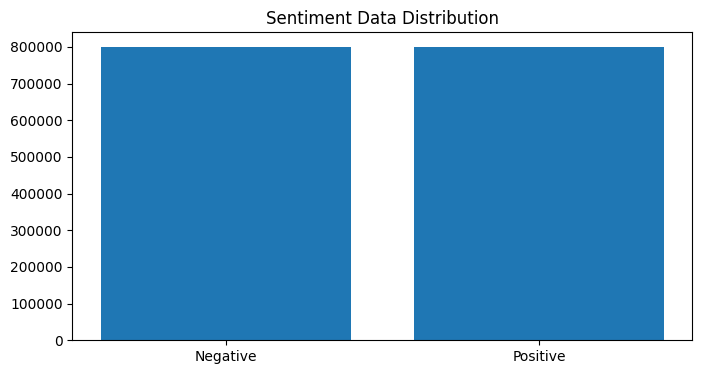

In [12]:
val_count = df.target.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [13]:
processed_tweets = []
for index, row in df.iterrows():
    processedtweet = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(row['text'])))))
    processed_tweets.append(processedtweet)
df['text'] = processed_tweets

In [14]:
df.head(10)

,target,text
0,Negative,awww thats a bummer you shoulda got david carr...
1,Negative,is upset that he cant update his facebook by t...
2,Negative,i dived many times for the ball managed to sav...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,no its not behaving at all im mad why am i her...
5,Negative,not the whole crew
6,Negative,need a hug
7,Negative,hey long time no see yes rains a bit only a bi...
8,Negative,nope they didnt have it
9,Negative,que me muera


In [15]:
train_size = 0.8
train_data, test_data = train_test_split(df, test_size = 1 - train_size, random_state = 0, stratify = df.target)
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))
print("Train data distribution:\n", train_data.target.value_counts())
print("Test data distribution:\n", test_data.target.value_counts())

Train data size:  1280000
Test data size:  320000
Train data distribution:
 Positive    640000
Negative    640000
Name: target, dtype: int64
Test data distribution:
 Negative    160000
Positive    160000
Name: target, dtype: int64


In [16]:
label_to_sentiments = {"Negative":0, "Positive":1}
def labels_decoder(label):
  return label_to_sentiments[label]
df.target = df.target.apply(lambda x: labels_decoder(x))
df.head(10)

,target,text
0,0,awww thats a bummer you shoulda got david carr...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...
5,0,not the whole crew
6,0,need a hug
7,0,hey long time no see yes rains a bit only a bi...
8,0,nope they didnt have it
9,0,que me muera


In [17]:
encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())
y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [19]:
max_length = max([len(s.split()) for s in train_data.text])
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen = max_length)
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape:  (1280000, 39)
x_test shape:  (320000, 39)
y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [20]:
embedding_dim = 200
def load_embedding(filename):
    file = open(filename,'r',encoding="utf-8")
    lines = file.readlines()
    file.close()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding
def get_weight_matrix(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = zeros((vocab_size, embedding_dim))
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

In [21]:
vocab = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocab_size)
print("Max length: ", max_length)
raw_embedding = load_embedding("C:/Users/ramya/Documents/Master Final Project/Phase 2/Project/glove.twitter.27B/glove.twitter.27B.200d.txt")
embedding_matrix = get_weight_matrix(raw_embedding, vocab)

Vocabulary size:  379093
Max length:  39


In [22]:
embedding_layer = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False)

In [23]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(200, dropout = 0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation = "sigmoid"))
print(model.summary())
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 200)           75818600  
                                                                 
 dropout (Dropout)           (None, 39, 200)           0         
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 76152329 (290.50 MB)
Trainable params: 333729 (1.27 MB)
Non-trainable params: 75818600 (289.23 MB)
_________________________________________________________________
None



In [24]:
BATCH_SIZE = 256
EPOCHS = 10
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,min_lr = 0.01)
history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,validation_split = 0.1, verbose = 1, callbacks = [reduce_lr])

Epoch 1/10


4500/4500 [==============================] - 933s 206ms/step - loss: 0.4435 - accuracy: 0.7906 - val_loss: 0.3950 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 2/10
4500/4500 [==============================] - 912s 203ms/step - loss: 0.4037 - accuracy: 0.8147 - val_loss: 0.3781 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 3/10
4500/4500 [==============================] - 938s 208ms/step - loss: 0.3891 - accuracy: 0.8229 - val_loss: 0.3726 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/10
4500/4500 [==============================] - 1015s 226ms/step - loss: 0.3802 - accuracy: 0.8279 - val_loss: 0.3676 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 5/10
4500/4500 [==============================] - 1061s 236ms/step - loss: 0.3739 - accuracy: 0.8311 - val_loss: 0.3665 - val_accuracy: 0.8363 - lr: 0.0010
Epoch 6/10
4500/4500 [==============================] - 1027s 228ms/step - loss: 0.3691 - accuracy: 0.8339 - val_loss: 0.3639 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 7/10
4500/4500 [=======

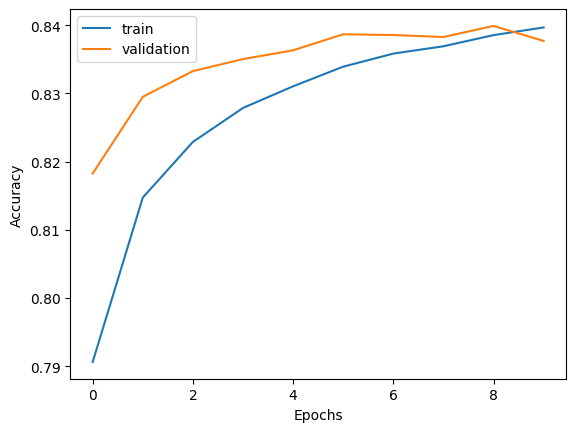

In [25]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

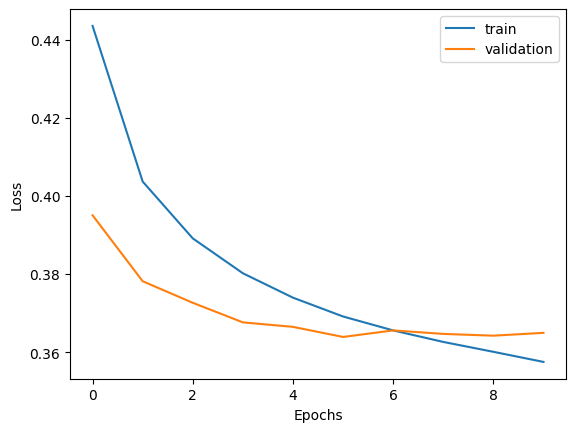

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)
test_accuracy = np.mean(y_pred.flatten() == y_test.flatten())
print(f'Test Set Accuracy: {test_accuracy:.4f}')

10000/10000 [==============================] - 166s 16ms/step
Test Set Accuracy: 0.8360


In [28]:
model.save("C:/Users/ramya/Documents/Master Final Project/Phase 2/Project/sentiment_analysis_model.h5")

C:\Users\ramya\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
from keras.models import load_model
label_sentiment = {0:"Negative", 1:"Positive"}
def label_decode(label):
  return label_sentiment[label]
loaded_model = load_model("C:/Users/ramya/Documents/Master Final Project/Phase 2/Project/sentiment_analysis_model.h5")
text = "The morning of a wedding is compete &quot;battery charge fest&quot; here"
new_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length)
pred = loaded_model.predict(new_text)
val = (pred > 0.5).astype(int)
label = label_decode(val.flatten()[0])
print(f"Text: {text}")
print(f"Sentiment Label: {label}")

1/1 [==============================] - 2s 2s/step
Text: The morning of a wedding is compete &quot;battery charge fest&quot; here
Sentiment Label: Positive


In [30]:
x_new = pad_sequences(tokenizer.texts_to_sequences(tweet_df['processed_tweet']), maxlen=max_length)
y_pred_prob_new = model.predict(x_new)
y_pred_new = (y_pred_prob_new > 0.5).astype(int)
tweet_df['sentiment'] = y_pred_new.flatten()
label_sentiment = {0:"Negative", 1:"Positive"}
def label_decode(label):
  return label_sentiment[label]
tweet_df.sentiment = tweet_df.sentiment.apply(lambda x: label_decode(x))
group_col = tweet_df.pop('group')
tweet_df.insert(len(tweet_df.columns), 'group', group_col)
tweet_df.head(10)

6789/6789 [==============================] - 130s 19ms/step


,tweet_id,post_text,parent_id,parent_user,create_date,tweet_length,emoticon_x,mention_count_x,hashtag_count_x,like_count,...,following_count,history_tweets,account_age,hashtag_count_y,mention_count_y,description_length,emoticon_y,processed_tweet,sentiment,group
0,1260590991641362436,So you left a 69 page guidebook but no PPE or ...,0,0,2020-05-13T15:21:27.000Z,278,0,0,0,301,...,1017.0,6,12.0,0,1,140,1,so you left a 69 page guidebook but no ppe or ...,Positive,0
1,1257296415849697280,How people act when they get a little bit of p...,1256955387066101760,111921,2020-05-04T13:09:59.000Z,139,0,0,1,19,...,1017.0,6,12.0,0,1,140,1,how people act when they get a little bit of p...,Positive,0
2,1288771853822103552,More tales from the NHS frontline are emerging...,0,0,2020-07-30T09:42:08.000Z,301,0,1,0,194,...,2835.0,5,12.0,0,1,158,0,more tales from the nhs frontline are emerging...,Negative,1
3,1251209120528637952,DEVELOPING: A crowd of protesters could be see...,0,0,2020-04-17T18:01:15.000Z,302,0,1,0,7650,...,7014.0,138,16.0,0,0,156,0,developing a crowd of protesters could be seen...,Negative,1
4,1339567071588442113,"Latest we expect on checks, *as of now*, per a...",0,0,2020-12-17T13:44:12.000Z,276,0,0,0,621,...,1405.0,100,12.0,0,2,156,0,latest we expect on checks as of now per aides...,Negative,0
5,1265997510738358272,Wisconsin election officials agree to send vot...,0,0,2020-05-28T13:25:02.000Z,93,0,0,0,959,...,1685.0,280,17.0,0,0,27,0,wisconsin election officials agree to send vot...,Positive,0
6,1262485169338036227,Trump says he is taking hydroxychloroquine to ...,0,0,2020-05-18T20:48:14.000Z,125,0,0,0,241,...,1685.0,280,17.0,0,0,27,0,trump says he is taking hydroxychloroquine to ...,Negative,0
7,1281796363869716485,CDC: Covid-19 death toll is twice as high amon...,0,0,2020-07-11T03:44:02.000Z,123,0,0,0,476,...,1685.0,280,17.0,0,0,27,0,cdc covid19 death toll is twice as high among ...,Negative,0
8,1244740000148787211,Opinion: Jerry Falwell Jr.’s coronavirus respo...,0,0,2020-03-30T21:35:16.000Z,113,0,0,0,1208,...,1685.0,280,17.0,0,0,27,0,opinion jerry falwell jrs coronavirus response...,Positive,0
9,1298387890746073096,"Opinion: Sorry, Democrats. Trump’s convention ...",1298345607812329478,91004,2020-08-25T22:32:50.000Z,81,0,0,0,1701,...,1685.0,280,17.0,0,0,27,0,opinion sorry democrats trumps convention is w...,Positive,0


In [31]:
import matplotlib.pyplot as plt
label_counts_lstm = tweet_df["sentiment"].value_counts()
print(label_counts_lstm)

Positive    121221
Negative     96010
Name: sentiment, dtype: int64


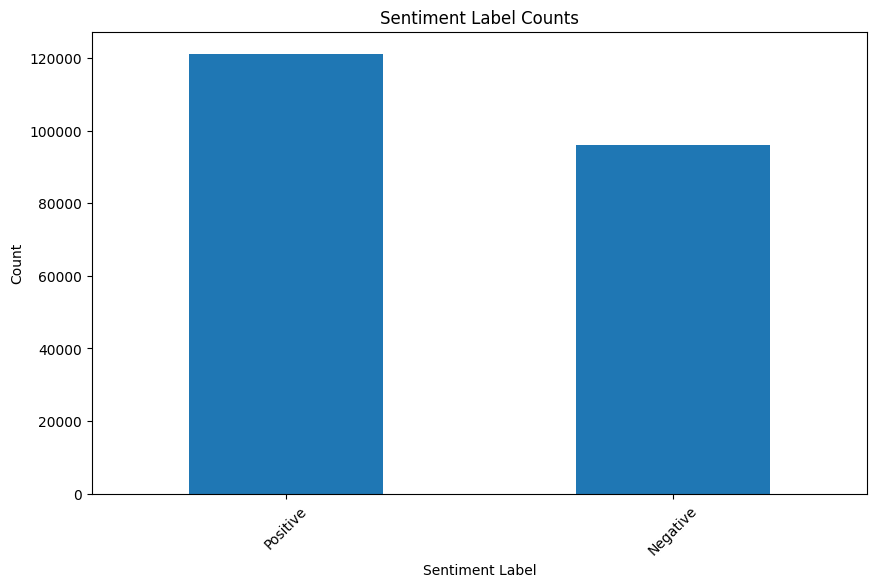

In [32]:
plt.figure(figsize=(10, 6))
label_counts_lstm.plot(kind='bar')
plt.title("Sentiment Label Counts")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [33]:
tweetdf_path = "C:/Users/ramya/Documents/Master Final Project/Phase 2/Project/sentiment.csv"
tweet_df.to_csv(tweetdf_path, index=False)

In [42]:
data_df_path = "C:/Users/ramya/Documents/Master Final Project/Phase 2/Project/data.csv"
data_df = pd.read_csv(data_df_path)
data_df.head()

,text,likes,retweets,following,followers,history_tweets,tweet_length,tweet_hashtag,tweet_mention,tweet_questionmark,tweet_emoji,bio_length,bio_hashtag,bio_mention,bio_emoji,account_age
0,"This is the new iPad Pro, available for $999 a...",3899,623,151,867147,6485,66,1,0,0,0,53,0,0,0,10


In [43]:
new1 = pad_sequences(tokenizer.texts_to_sequences(data_df['text']), maxlen=max_length)
newpred = model.predict(new1)
y_newpred = (newpred > 0.5).astype(int)
data_df['sentiment'] = y_newpred.flatten()
data_df.head()

1/1 [==============================] - 0s 31ms/step


,text,likes,retweets,following,followers,history_tweets,tweet_length,tweet_hashtag,tweet_mention,tweet_questionmark,tweet_emoji,bio_length,bio_hashtag,bio_mention,bio_emoji,account_age,sentiment
0,"This is the new iPad Pro, available for $999 a...",3899,623,151,867147,6485,66,1,0,0,0,53,0,0,0,10,1


In [48]:
data_df.drop(['text'], axis=1, inplace=True)

In [49]:
data_df.head()

,likes,retweets,following,followers,history_tweets,tweet_length,tweet_hashtag,tweet_mention,tweet_questionmark,tweet_emoji,bio_length,bio_hashtag,bio_mention,bio_emoji,account_age,sentiment
0,3899,623,151,867147,6485,66,1,0,0,0,53,0,0,0,10,1


In [50]:
datapath = "C:/Users/ramya/Documents/Master Final Project/Phase 2/Project/processeddata.csv"
data_df.to_csv(datapath, index=False)